In [36]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import statistics
import sys,os
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,IsolationForest
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import sklearn.metrics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
# import maha
import scipy
from scipy.spatial import distance
matplotlib.rcParams["font.size"] = 15
from IPython.display import Image


In [37]:
#Helpers
'''
Usage: x = test_data, data = train_data
'''
def maha_pinv2(x=None, data=None, cov=None):
    x = np.array(x)
    x_mu = np.array(np.mean(data))
#     print(x_mu)
    if not cov:  
        cov = np.cov(data.T, rowvar = True, bias = False)
    print('Shape of covariance: ', cov.shape)
#     print('covariance: ', cov)
    inv_covmat = scipy.linalg.pinv2(cov)
    print('Shape of inverse of covariance: ', inv_covmat.shape)
    maha_dists = []
    for i in range(len(x)):
        d = x[i]
        dist = distance.mahalanobis(x_mu, d, inv_covmat)
        maha_dists.append(dist)
    return maha_dists

def maha4(x=None, data=None, cov=None):
    x = np.array(x)
    x_mu = np.array(np.mean(data))
#     print(x_mu)
    if not cov:  
        cov = np.cov(data.T, rowvar = True, bias = False)
    print('Shape of covariance: ', cov.shape)
    inv_covmat = scipy.linalg.pinvh(cov)
    print('Shape of inverse of covariance: ', inv_covmat.shape)
    maha_dists = []
    for i in range(len(x)):
        d = x[i]
        dist = distance.mahalanobis(x_mu, d, inv_covmat)
        maha_dists.append(dist)
    return maha_dists


# """
# Helper method to generate precision vs recall plot.

# return:      precision, recall, accuracy of a cutoff th1
# """
# def precision_recall(X_test_x0, th1, distance ):
#     TP = 0
#     TN = 0
#     FN = 0
#     FP = 0
#     test_x0 = list( X_test_x0 )
#     for i in range( len( test_x0 )   ):
#         x = test_x0[i]
#         d = distance[i]
#         if x == 'Cu':
#             if d <  th1:
#                 TP += 1
#             else:
#                 FN += 1
#         else:
#             if d >= th1:
#                 TN += 1
#             else:
#                 FP += 1
#     precision = TP/ (TP + FP)
#     recall = TP / (TP + FN)
#     total = len(test_x0)
#     accuracy = (TP+TN)/ total
#     cf_inout = {
#         'Actual_yes':{'Predicted_yes':TP, "Predicted_no":FN},
#         'Actual_no':{'Predicted_yes':FP , "Predicted_no":TN}  
#     }
#     df_inout = pd.DataFrame(cf_inout)
#     return [precision, recall,accuracy, df_inout]




# """
# Compute mahalanobis distance
# """
# def mahalanobis(x=None, data=None, cov=None):

#     x_mu = np.array(x) - np.array(np.mean(data))
# #     dt = np.dtype('c16')
#     if not cov:
        
#         cov = np.cov(data.T, rowvar = True, bias = False)
# #         cov = cov_func(data.T)
# #         cov = np.random.rand(24,24).astype(type( x.iloc[0][0] ))
        
#     inv_covmat = np.linalg.inv(cov)
# #     print(inv_covmat)
#     left = np.dot(x_mu, inv_covmat)
#     mahal = np.dot(left, x_mu.T)
    
#     return mahal.diagonal()


# """
# buggy because np.linalog.inv
# """
    
# def maha2(x=None, data=None, cov=None):
#     x = np.array(x)
#     x_mu = np.array(np.mean(data))
# #     print(x_mu)
#     if not cov:      
#         cov = np.cov(data.T, rowvar = True, bias = False)
#     print(cov.shape)
#     inv_covmat = np.linalg.inv(cov)

#     maha_dists = []
#     for i in range(len(x)):
#         d = x[i]
#         dist = distance.mahalanobis(x_mu, d, inv_covmat)
#         maha_dists.append(dist)
#     return maha_dists



In [38]:
df = pd.read_csv('train_test_6k.csv')
df.head()

,x0,x1,x2,x3,x4,y
0,0.417022,0.720324,0.000114,0.302333,0.146756,16.852205
1,0.092339,0.186260,0.345561,0.396767,0.538817,7.678848
2,0.419195,0.685220,0.204452,0.878117,0.027388,18.513197
3,0.670468,0.417305,0.558690,0.140387,0.198101,10.164178
4,0.800745,0.968262,0.313424,0.692323,0.876389,18.487972


In [39]:
features = list( df.columns[:-1] ) # we exclude y because it's the target value
features

['x0', 'x1', 'x2', 'x3', 'x4']

# Perform data splitting
1. randomly pick 50% as training data (X_train, y_train) and the rest are test data We will use 
the X_train and X_test in 2 situations:<br>

   1) Since mahalanobis distance compute the distance from a an observation of the data to the centroid of a cluster of data,we<br>
      will use training data X_train as the cluster and an sample from X_test as an observatoin.
   2) MASTML will train on X_train and y_train and test (called "leave-out" in mastml) on X_test, y_test

In [40]:
X = df[features]
y = df['y']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=42)

#### Now, let's compute the mahalanobis distance

2. we will use each sample from X_test as an observation of data, and compute the distance <br>from this observation to the centroid of data, in this case, X_train <br>
   
&emsp;&emsp;input: x = X_test &emsp;&emsp;&emsp;&emsp;a set of data. We want to obtain mahalanobis disatnce for each sample in it.<br>
&emsp;&emsp;&emsp;&emsp;&emsp;data = X_train&emsp;&emsp;If an observation from X_test looks similar to the cluster X_train it will has a smaller mahalanobis distance<br>
&emsp;&emsp;return: a list of maha distance for each sample in X_test

In [41]:
maha_pinv2_list = maha_pinv2(x = X_test, data = X_train) # pinv2 means it use pseudo - inverse for matrix
# maha_pinv2_list = maha2(x = X_test, data = X_train)

Shape of covariance:  (5, 5)
Shape of inverse of covariance:  (5, 5)


In [42]:
# constuct dataframe for latter testing
test_df = X_test.copy()
test_df['y'] = y_test
test_df['maha'] = maha_pinv2_list
test_df.reset_index(drop=True, inplace=True)
print(test_df.shape)
test_df.head()

(3000, 7)


,x0,x1,x2,x3,x4,y,maha
0,0.580157,0.971171,0.992099,0.202873,0.444520,18.896676,2.554921
1,0.844592,0.746864,0.865975,0.731970,0.249498,20.413543,2.296869
2,0.588367,0.855190,0.604672,0.822578,0.879484,22.841829,2.225047
3,0.603577,0.497602,0.971110,0.071572,0.742047,16.961318,2.344893
4,0.793465,0.537437,0.048907,0.267570,0.096989,16.964469,2.506194


In [43]:
# sort df by maha distance with ascending order
sorted_test = test_df.sort_values(by = 'maha')
sorted_test.reset_index(drop=True, inplace=True)
sorted_test

,x0,x1,x2,x3,x4,y,maha
0,0.575964,0.539049,0.459349,0.547686,0.541084,16.494480,0.406543
1,0.455898,0.545902,0.378495,0.504680,0.472674,14.751483,0.505927
2,0.518962,0.476540,0.536882,0.528255,0.659485,15.618155,0.551118
3,0.404261,0.562261,0.577762,0.478871,0.584093,14.379373,0.571832
4,0.460643,0.421394,0.572428,0.572090,0.616774,14.636909,0.585172
...,...,...,...,...,...,...,...
2995,0.963984,0.155984,0.983608,0.081212,0.039612,10.237858,3.414860
2996,0.987380,0.962316,0.997030,0.732961,0.031129,13.985048,3.431363
2997,0.134506,0.007682,0.982191,0.047674,0.105378,5.686248,3.481458
2998,0.998521,0.139649,0.070542,0.073467,0.014744,8.739013,3.494398


Text(0, 0.5, 'mahalanobis distance')

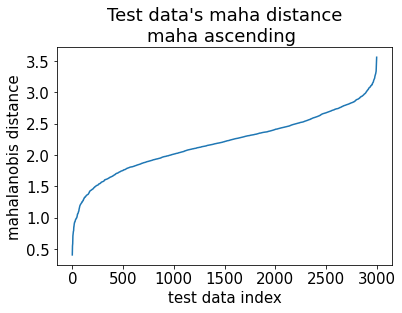

In [44]:
fig,ax = plt.subplots()
ax.plot( sorted_test['maha'])
ax.set_title("Test data's maha distance\nmaha ascending ")
ax.set_xlabel("test data index")
ax.set_ylabel('mahalanobis distance')

In [45]:
"""
More test sets (1-10) to catch really close and really far regions. - Yiqi, Avy
Do close Test 1 and far Test 2. Stanley, Jodie (Use the test1(nearest) and test10(farests) in the notebook)
"""
test_split_num = 10
# we have 10 tests. We split sorted_test evenly to test1,2,3,...10
test_size = int( sorted_test.shape[0] / 10 )
test_size

300

In [46]:
# a dictionary holds all tests, format: { "test_n": data_frame, ....}
tests = {}
for i in range(test_split_num):
    test_name = f"test_{i+1}"
    tests[test_name] = sorted_test.iloc[i*test_size: test_size*(i+1)]
    tests[test_name].reset_index(drop=True, inplace=True)
    # get rid of maha distance, it's just for sorting
    tests[test_name] = tests[test_name].drop('maha', axis = 1)
    # VERY IMPORTANT, if the entry in leave_out column is 1, 
    # mastml can identify these sample as test data (leave-out), so it won't train on it!
    tests[test_name]['leave_out'] = 1

In [47]:
test_1 = tests['test_1'] # very near test for  Stanley, Jodie

In [48]:
test_10 = tests['test_10'] # very far test for  Stanley, Jodie

In [49]:
# construct training data for mastml
train_df = X_train.copy()
train_df['y'] = y_train
train_df.reset_index(drop=True, inplace=True)
# leaveout column all 0 because these are training data.
# Mastml should do training and nested cross validation for it
train_df['leave_out'] = 0
train_df

,x0,x1,x2,x3,x4,y,leave_out
0,0.205116,0.707143,0.624922,0.756035,0.299970,13.773013,0
1,0.423566,0.283326,0.491772,0.397476,0.753117,11.423156,0
2,0.202296,0.358321,0.325332,0.933607,0.472139,14.564564,0
3,0.213097,0.765921,0.556923,0.397080,0.568637,11.784602,0
4,0.613091,0.602007,0.896572,0.026473,0.419895,14.675679,0
...,...,...,...,...,...,...,...
2995,0.144281,0.807600,0.431221,0.280176,0.980560,11.378594,0
2996,0.392141,0.556795,0.900167,0.930884,0.260546,20.148261,0
2997,0.278305,0.499751,0.903181,0.755432,0.840579,19.240031,0
2998,0.330806,0.806071,0.388345,0.604563,0.551132,16.481798,0


In [52]:
# final data frame ready to tranform to csv, and latter used by MASTML for very near, far test
train_test1 = pd.concat([train_df, test_1], ignore_index = True, axis = 0)
train_test10 = pd.concat([train_df, test_10], ignore_index = True, axis = 0)

In [55]:
# copy those files to the folder where MASTML can access later
train_test1.to_csv('fried_6k_test1.csv', index = False)
train_test10.to_csv('fried_6k_test10.csv', index = False)

In [56]:
train_test1

,x0,x1,x2,x3,x4,y,leave_out
0,0.205116,0.707143,0.624922,0.756035,0.299970,13.773013,0
1,0.423566,0.283326,0.491772,0.397476,0.753117,11.423156,0
2,0.202296,0.358321,0.325332,0.933607,0.472139,14.564564,0
3,0.213097,0.765921,0.556923,0.397080,0.568637,11.784602,0
4,0.613091,0.602007,0.896572,0.026473,0.419895,14.675679,0
...,...,...,...,...,...,...,...
3295,0.592936,0.674710,0.535963,0.177874,0.245701,12.544257,1
3296,0.459116,0.573452,0.574059,0.842131,0.240442,17.093075,1
3297,0.628456,0.662825,0.146060,0.344172,0.425888,17.734992,1
3298,0.857072,0.628552,0.442004,0.429792,0.283216,15.707397,1


### we have done for generating data, now let's shit to MASTML 

### MASTML runs requires few minutes usually, we can do the setup below

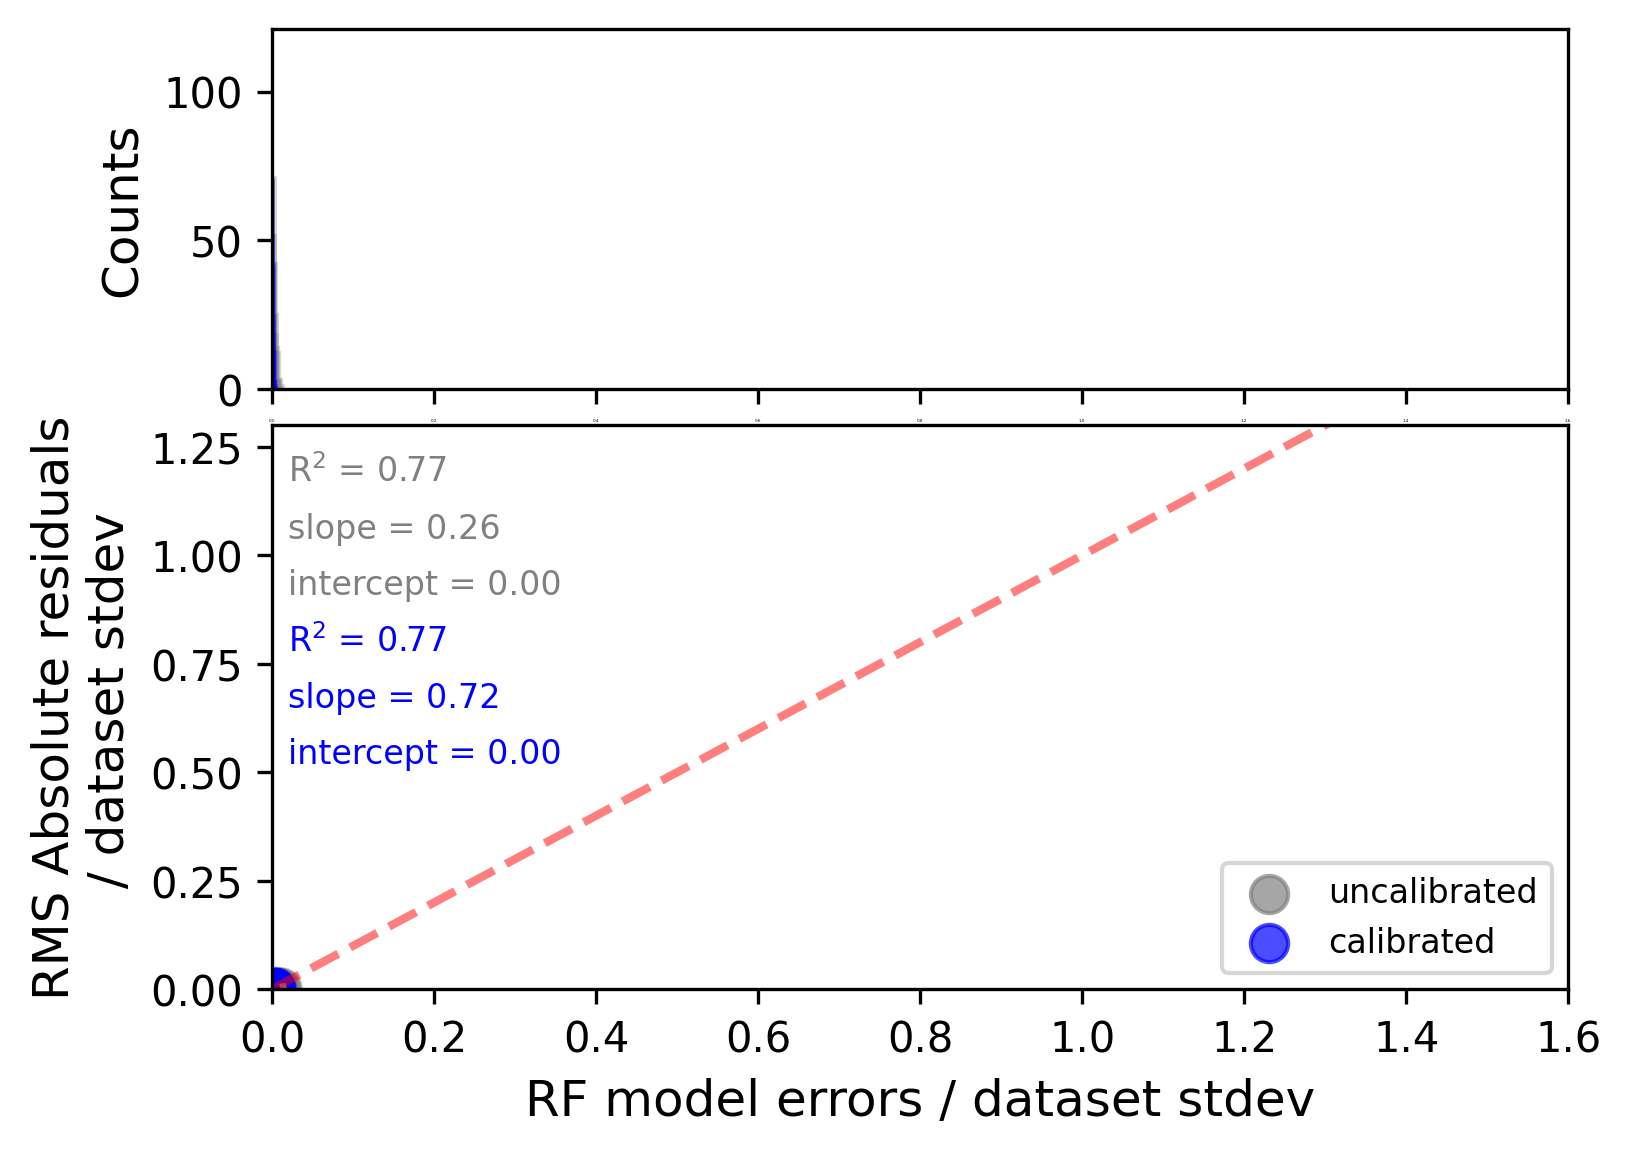

In [59]:
# test1: very small maha test
plot_name = "RF_residuals_vs_modelerror_leaveout_uncal_cal_overlay.png"
# the folder mastml generage, do change this based on the actual folder name on your device
folder = "RandomForestRegressor_RepeatedKFold_SklearnPreprocessor_NoSelect_06_14_14_21_35"
# change this.
parent = './../MASTML_Fried_6ktest1'

path_small= os.path.join(parent, folder, plot_name ) # Supercon_data_features_selected.xlsx
# print(path, '\n', path_small, sep = '')
Image(filename = path_small)

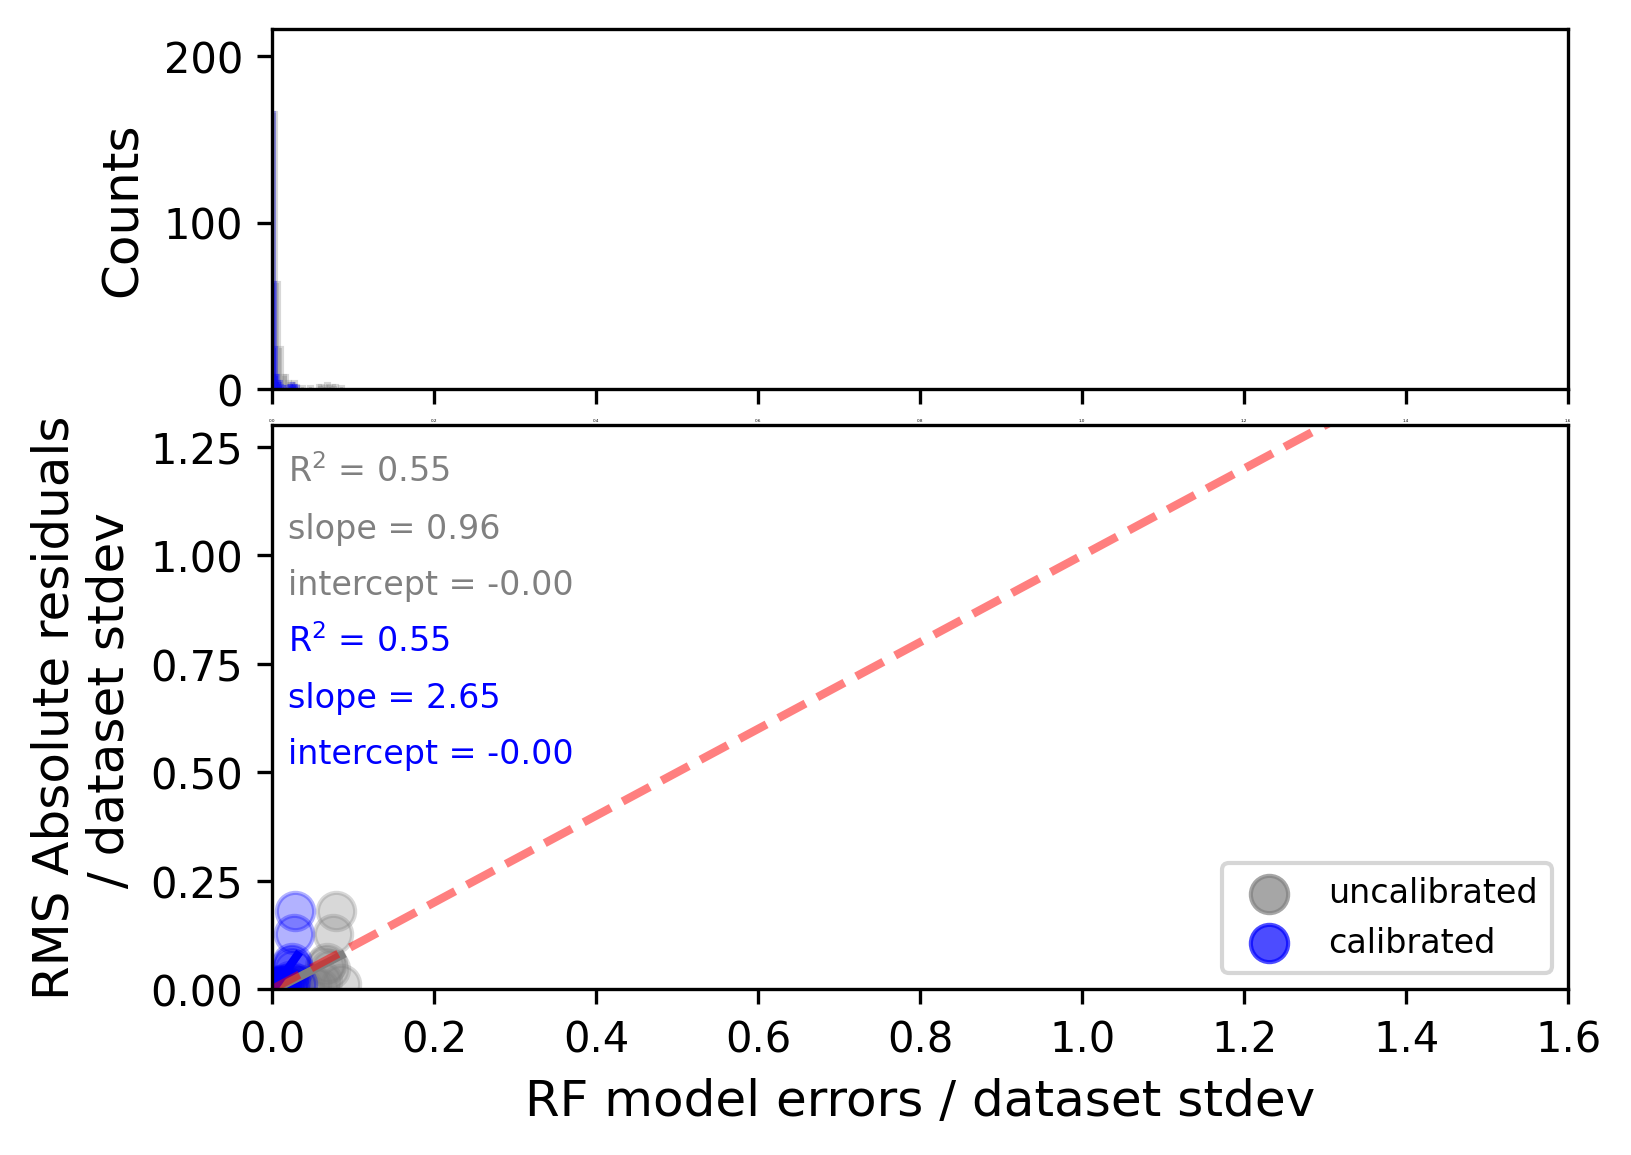

In [61]:
# # large 
plot_name = "RF_residuals_vs_modelerror_leaveout_uncal_cal_overlay.png"
folder = "RandomForestRegressor_RepeatedKFold_SklearnPreprocessor_NoSelect_06_14_14_36_51"
parent = './../MASTML_Fried_6ktest10'

path_middle= os.path.join(parent, folder, plot_name ) # Supercon_data_features_selected.xlsx

Image(filename = path_middle)

In [ ]:
# # largemaha
plot_name = "RF_residuals_vs_modelerror_leaveout_uncal_cal_overlay.png"
folder = "RandomForestRegressor_RepeatedKFold_SklearnPreprocessor_NoSelect_06_08_16_17_07"
parent = './../MASTML_LargeFried'

path_large= os.path.join(parent, folder, plot_name ) # Supercon_data_features_selected.xlsx

Image(filename = path_large)

In [ ]:
# MASTML_MIXFried
plot_name = "RF_residuals_vs_modelerror_leaveout_uncal_cal_overlay.png"
folder = "RandomForestRegressor_RepeatedKFold_SklearnPreprocessor_NoSelect_06_10_23_19_19"
parent = './../MASTML_MIXFried'

path_large= os.path.join(parent, folder, plot_name ) # Supercon_data_features_selected.xlsx

Image(filename = path_large)